#### Final Project: Rick & Morty analysis

# Phase 3: Exploring Data (Laurine)

In [1]:
# imports
import pandas as pd
import ast
import networkx as nx
import matplotlib.pyplot as plt
import codecs
import numpy as np

## 1.3. Finding the “favourite words” of the Smith/Sanchez family

**Focus on characters: Rick Sanchez, Morty Smith, Beth Smith, Jerry Smith, Summer Smith**

### REPORT

What the Kaggle study found: https://www.kaggle.com/andradaolteanu/sentiment-analysis-rick-and-morty-scripts (see "most 10 words from the Smith family" plots)

#### 1st approach
- I only used the transcript database of the Kaggle study we found on Sentiment Analysis
- Pre-processing = lower case + exclude characters' name + NLTK tokenization + NLTK lemmatization + remove words with 2 letters or less

**CCL** : 
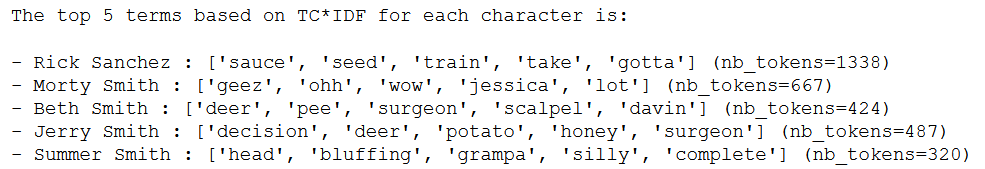

We clearly need more words, especially for Beth, Jerry and Summer! We identify the words from the first episode, when Beth is saving a shot deer.

## Generate data files (tokens)

In [2]:
# load data
df_transcripts = pd.read_csv('transcripts/RickAndMortyScripts.csv')
df_transcripts.head()

,season no.,episode no.,episode name,name,line
0,1,1,Pilot,Rick,Morty! You gotta come on. Jus'... you gotta co...
1,1,1,Pilot,Morty,"What, Rick? What’s going on?"
2,1,1,Pilot,Rick,"I got a surprise for you, Morty."
3,1,1,Pilot,Morty,It's the middle of the night. What are you tal...
4,1,1,Pilot,Rick,"Come on, I got a surprise for you. Come on, h..."


In [3]:
# create a text with lines of for each character

family_list = {
    'Rick':'Rick Sanchez',
    'Morty':'Morty Smith',
    'Beth':'Beth Smith',
    'Jerry':'Jerry Smith',
    'Summer':'Summer Smith'}

dict_text = {k:"" for k in family_list.keys()}

def add_line_to_text(aRow):
    if aRow['name'] in family_list:
        dict_text[aRow['name']] += (' '+str(aRow['line']))

_ = df_transcripts.apply(add_line_to_text, axis=1)

In [4]:
# save the text of each character
for aCharacter, aString in dict_text.items():
    f = codecs.open('character_words/'+family_list[aCharacter]+'.txt', "w+", "utf-8")
    f.write(aString)
    f.close()

In [5]:
from os import listdir
from os.path import isfile, join

import nltk
from nltk.tokenize import WordPunctTokenizer

In [6]:
# apply the tokenization process

pages_path = 'character_words'
all_files = [f for f in listdir(pages_path) if isfile(join(pages_path, f))]

In [7]:
# get the stopwords list in given language
stopwords = nltk.corpus.stopwords.words('english')
# tokenization factory
tk = WordPunctTokenizer()
# lemmatization factory
lm = nltk.WordNetLemmatizer()

# for each character
for aFile in all_files:
    # Read the file containing the character's page description.
    character_page = open(pages_path+'/'+aFile, encoding="utf-8").read() 
    # Set everything to lower case.
    character_page = character_page.lower()
    # Exclude characters names, BEFORE tokenisation
    for aCharacterName in family_list.keys():
        character_page = character_page.replace(aCharacterName.lower(),'')
    # Tokenize your text
    character_page = tk.tokenize(character_page)
    # Exclude punctuation and stop words
    character_page = [aToken for aToken in character_page if aToken.isalnum() and aToken not in stopwords]
    # Lemmatize words
    character_page = [ lm.lemmatize(w) for w in character_page ]
    # Remove words with less than 2 letters
    character_page = [ w for w in character_page if len(w)>2]
    # Transform list into list separated by spaces
    character_page = ''.join([str(elem)+' ' for elem in character_page])
    # Save your output for future use
    f = codecs.open('character_words_tokens/'+aFile, "w+", "utf-8")
    f.write(character_page)
    f.close()

## Overview of the whole family words

In [8]:
from nltk.corpus import PlaintextCorpusReader

In [9]:
# create NLTK objects: Corpus and Text
corpus_root = 'character_words_tokens'
familyCorpus = PlaintextCorpusReader(corpus_root, all_files)
familyText = nltk.Text(familyCorpus.words())

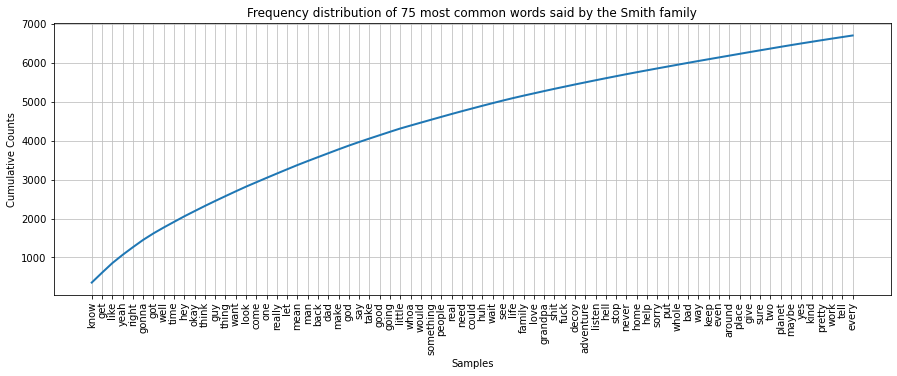

In [10]:
# get the freq distribution of tokens
fdist_family = nltk.FreqDist(familyText)
nb_words = 75
fdist_family.most_common(nb_words)
plt.figure(figsize=(15,5))
plt.title(f'Frequency distribution of {nb_words} most common words said by the Smith family')
fdist_family.plot(nb_words, cumulative=True)
plt.show()

## The favourites words of each character from the Smith family >> TC-IDF

Why TC? Better to plot wordclouds later.

In [11]:
# get one document (of tokens) per character
char_documents = {aCharacter:nltk.Text(familyCorpus.words([aCharacter+'.txt'])) for aCharacter in family_list.values()}

In [12]:
# compute the TC of each character
char_fdist = {aCharacter:nltk.FreqDist(aText) for aCharacter, aText in char_documents.items()}

def getTC(t, aFdist):
    """ Get the term count of a term t in a document d whose we already computed the frequency distribution aFdist"""
    return aFdist[t]

def find_top_5_terms(aText):
    """ Find the 5 most common terms in the text """
    fdist = nltk.FreqDist(aText)
    fdist = dict(fdist.most_common(5))
    return {k:v/len(aText) for k,v in fdist.items()}

# find the top 5 terms for each character based on TC
family_top_5_terms = {aChar:find_top_5_terms(aCharText) for aChar, aCharText in char_documents.items()}

# print results
print("The top 5 terms for each character is:\n")
for aChar, aListOfTerms in family_top_5_terms.items():
    print("- {} : {}".format(aChar, list(aListOfTerms.keys())))

The top 5 terms for each character is:

- Rick Sanchez : ['get', 'know', 'gonna', 'right', 'like']
- Morty Smith : ['know', 'like', 'get', 'right', 'yeah']
- Beth Smith : ['dad', 'know', 'okay', 'like', 'want']
- Jerry Smith : ['well', 'know', 'like', 'hey', 'guy']
- Summer Smith : ['grandpa', 'god', 'yeah', 'like', 'dad']


In [13]:
# compute the IDF for every word
def getIDF(t,D, fdist_dic):
    """ Get the inverse document frequency of a term t among the corpus D whose we give the frequency distributions fdist_dic """
    N = len(D)
    nb_texts_with_term = 1 + sum([1 if getTC(t,fdist_dic[a]) else 0 for a in list(D.keys()) ])
    return np.log10(N/nb_texts_with_term)

all_words_IDFs = {aTerm:getIDF(aTerm, char_documents, char_fdist) for aTerm in familyText}

In [14]:
# compute TC-IDF
def getTC_IDF(t,aFdist):
    """ get the TC*IDF for a term t, a document d from a corpus D (here, a dictionary of Texts) """
    return getTC(t, aFdist) * all_words_IDFs[t]

family_TC_IDF = {aChar:{aTerm:getTC_IDF(aTerm, char_fdist[aChar]) for aTerm in aText } for aChar,aText in char_documents.items() }
family_TC_IDF_sorted = {aChar:dict(sorted(aTCIDF_dic.items(), reverse=True, key=lambda x:x[1])) for aChar, aTCIDF_dic in family_TC_IDF.items()}

# print results
print("The top 5 terms based on TC*IDF for each character is:\n")
for aChar, aTC_IDF_dic in family_TC_IDF_sorted.items():
    print("- {} : {} (nb_tokens={})".format(aChar, list(aTC_IDF_dic)[:5], len(list(aTC_IDF_dic) )))

The top 5 terms based on TC*IDF for each character is:

- Rick Sanchez : ['sauce', 'number', 'bunch', 'season', 'piece'] (nb_tokens=2952)
- Morty Smith : ['ohh', 'duane', 'geez', 'ohhhh', 'bawk'] (nb_tokens=1449)
- Beth Smith : ['surgeon', 'cling', 'performing', 'surgery', 'davin'] (nb_tokens=746)
- Jerry Smith : ['apple', 'pluto', 'tru', 'award', 'potato'] (nb_tokens=1139)
- Summer Smith : ['drum', 'needful', 'bluffing', 'nancy', 'ethan'] (nb_tokens=792)


# Topic detection

In [ ]:
import gensim
import gensim.corpora as corpora
from gensim.models import CoherenceModel

In [ ]:
# create a list of lists with clean description of each character
family_tokens_dict = {}

for aName, aFullName in family_list.items():
    character_page = open(corpus_root+'/'+aFullName+'.txt', encoding="utf-8").read() 
    family_tokens_dict[aName] = character_page.split(' ')

In [ ]:
# build the dictionary id2word by using corpora.Dictionary(YOUR_LIST_OF_LISTS)
id2word = corpora.Dictionary(list(family_tokens_dict.values()))

In [ ]:
# build your corpus by mapping the words in YOUR_LIST_OF_LISTS as follows id2word.doc2bow(PAGE)
# Bag-of-words representation of the documents.
corpus = [id2word.doc2bow(doc) for doc in list(family_tokens_dict.values())]

In [ ]:
# run the LDA model with input id2word and your corpus
LDA_model_test = gensim.models.LdaMulticore(corpus=corpus, id2word=id2word, alpha=0.3)

In [ ]:
# build many LDA models with different values of number of topics 𝑁𝑡
number_of_topics_values = [1,2,5,10,20,40]
coherence_score_dict = {}

for aNumberOfTopics in number_of_topics_values:
    aLDAmodel = gensim.models.LdaMulticore(corpus=corpus, id2word=id2word, num_topics=aNumberOfTopics)
    top_topics = aLDAmodel.top_topics(corpus)
    avg_topic_coherence = sum([t[1] for t in top_topics]) / aNumberOfTopics
    coherence_score_dict[aNumberOfTopics]=avg_topic_coherence
    # print("For {} topics, we obtain a coherence score of {}".format(aNumberOfTopics, avg_topic_coherence))

# plot the coherence score
plt.plot(coherence_score_dict.keys(), coherence_score_dict.values(), marker='o', linestyle='--')
plt.title("Coherence score based on the number of topics")
plt.xlabel("Number of topics")
plt.ylabel("Avg topic coherence")
plt.show()

In [ ]:
# get best model

# Pick the 𝑁𝑡 that gives the highest coherence value. 
coherence_score_dict = dict(sorted(coherence_score_dict.items(), reverse=True, key=lambda x: x[1]))
best_Nt = list(coherence_score_dict.keys())[0]
best_coherence_score = coherence_score_dict[best_Nt]
print("The best number of topics is {} which results a coherence score of {}".format(best_Nt, best_coherence_score))
best_LDAmodel = gensim.models.LdaMulticore(corpus=corpus, id2word=id2word, num_topics=best_Nt)

In [ ]:
best_LDAmodel.show_topics()

## Sentiment analysis of their words: how do they interact to each other? which sentiments do they express ?

Use of NRC lexicon : https://saifmohammad.com/WebPages/NRC-Emotion-Lexicon.htm

In [15]:
df_NRC = pd.read_csv('lexicons/NRC_sentiment_lexicon.csv')
df_NRC_VAD = pd.read_csv('lexicons/NRC-VAD-Lexicon.csv')

In [16]:
def combine_lines(aDataFrame):
    result = ''
    for _, aRow in aDataFrame.iterrows():
        result += aRow.line+' '
    return result

def get_word_tokens(aTextOfLines):
    """ Lower + tokenization + remove punctuation """
    # Set to lower case
    aTextOfLines = aTextOfLines.lower()
    # Tokenize
    tokens = tk.tokenize(aTextOfLines)
    # Remove punctuation
    tokens = [aToken for aToken in tokens if aToken.isalnum()]
    # Lemmatize 
    tokens = [ nltk.WordNetLemmatizer().lemmatize(w) for w in tokens ]
    return tokens

def analyse_text_NRC(aText):
    """ Get the NRC sentments + VAD scores of a given text (aText)
    Output : dict of VAD scores / dict of sentiments scores / tokens / text"""
    tokens = get_word_tokens(aText)
    
    result_sentiments_df = df_NRC[df_NRC.Word.isin(tokens)]
    result_VAD_df = df_NRC_VAD[df_NRC_VAD.Word.isin(tokens)]
    
    result_sentiments_dict = result_sentiments_df.sum().drop('Word')/len(result_sentiments_df)
    result_VAD_dict = result_VAD_df.sum().drop('Word')/len(result_VAD_df)
    result_sentiments_dict = dict(sorted(result_sentiments_dict.items(), reverse=True, key=lambda x:x[1]))
    result_VAD_dict = dict(sorted(result_VAD_dict.items(), reverse=True, key=lambda x:x[1]))
    
    return {'VAD scores':result_VAD_dict, 'sentiment scores':result_sentiments_dict, 'tokens':tokens, 'lines':aText}

def analyse_interactions_NRC(source_char, target_char):
    """ Get the NRC sentiments + VAD scores when source_char talk to target_char """
    text = combine_lines(df_transcripts[(df_transcripts.name==source_char) & (df_transcripts.line.str.contains(target_char))])
    return analyse_text_NRC(text)

def analyse_one_char_words(source_char):
    """ Get the NRC sentiments + VAD scores for only source_char lines """
    text = combine_lines(df_transcripts[df_transcripts.name==source_char])
    return analyse_text_NRC(text)

Detail of VAD score:
- valence: from NEGATIVE/DISPLEASURE to POSITIVE/PLEASURE
- arousal: from CALM/PASSIVE to EXCITED/ACTIVE
- dominance: FROM WEAK/CONTROLLED to POWERFUL/CONTROL

In [17]:
source_char, target_char = 'Beth','Jerry'

In [ ]:
source_char, target_char = 'Jerry','Beth'

In [32]:
source_char, target_char = 'Rick','Morty'

In [34]:
source_char, target_char = 'Beth','Morty'

In [35]:
results = analyse_interactions_NRC(source_char,target_char)

In [ ]:
source_char, target_char = 'Rick',"that's it"

In [ ]:
source_char, target_char = 'Morty',"that's it"

In [ ]:
results = analyse_one_char_words(source_char)

Get results

In [37]:
source_char, target_char

('Beth', 'Morty')

In [38]:
results['VAD scores']

{'Valence': 0.608225,
 'Dominance': 0.5193749999999999,
 'Arousal': 0.45036249999999994}

In [39]:
# print concerned words
sentiment_focus = 'Dominance'
print(list((df_NRC_VAD[(df_NRC_VAD.Word.isin(results['tokens'])) & (df_NRC_VAD[sentiment_focus]>0.5)]['Word'])))

['adventure', 'appreciate', 'arbitrary', 'be', 'blow', 'class', 'dad', 'discipline', 'don', 'first', 'friend', 'fully', 'fun', 'get', 'good', 'guy', 'have', 'high', 'home', 'house', 'influence', 'kiss', 'know', 'life', 'living', 'look', 'love', 'mom', 'obsession', 'practice', 'project', 'robotic', 'run', 'school', 'science', 'summer', 'superhero', 'sweetheart', 'therapy', 'think', 'time', 'will', 'work']


In [40]:
results['sentiment scores']

{'Positive': 0.5416666666666666,
 'Negative': 0.4166666666666667,
 'Anticipation': 0.2916666666666667,
 'Joy': 0.2916666666666667,
 'Sadness': 0.25,
 'Trust': 0.25,
 'Disgust': 0.125,
 'Fear': 0.125,
 'Anger': 0.08333333333333333,
 'Surprise': 0.08333333333333333}

In [23]:
# print concerned words
sentiment_focus = 'Anger'
print(list((df_NRC[(df_NRC.Word.isin(results['tokens'])) & (df_NRC[sentiment_focus])]['Word'])))

['bear', 'bitch', 'confront', 'crazy', 'hell', 'hit', 'homeless', 'kick', 'prisoner', 'screaming', 'terrible']


In [ ]:
print(results['tokens'])

In [41]:
results['lines']

"Morty, are you getting sick?  I told you not to practice-kiss the living room pillow. The dog sleeps on it. Look, I appreciate the stress you're under, but Morty was having trouble in school way before my dad moved in, and the only influence I can see Rick having is that, for the first time in his life, Morty has a friend. Oh, don't high-road us, dad. You know fully well that Morty is the last child that needs to be missing classes. Summer, Morty, are you okay? Hey guys, we're home.Morty & Summer Morty, we have to get going, or we're gonna be late. Where's your grandpa? Morty! Morty, Mom's talking. I'm sorry, I suppose that's a good segue into our little discipline cases here. Well, Dr. Wong -- by the way, racist name -- obviously, Morty and Summer are seizing on your arbitrary pickle obsession as an end run around what was supposed to be their therapy. Morty, you're wearing a Vindicator jacket. Are you a little superhero now? Can you please make Morty fourteen again, dad? This is rid

In [42]:
# use VADER package
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

In [27]:
# generate all lexicons
all_lexicons = {}
for element in ['Arousal','Dominance','Valence']:
    all_lexicons[element]= {aRow.Word:8*aRow[element]-4 for _, aRow in df_NRC_VAD[['Word',element]].iterrows()}
for element in df_NRC.drop('Word',axis=1).columns:
    all_lexicons[element] = {aRow.Word:8*aRow[element]-4 for _, aRow in df_NRC[['Word',element]].iterrows()}

In [43]:
print("For {} to {}\n".format(source_char, target_char))
to_study=['Arousal', 'Dominance', 'Valence', 'Positive', 'Negative', 'Anger', 'Anticipation', 'Disgust', 'Fear', 'Joy', 'Sadness', 'Surprise', 'Trust']
for aSentiment, aLexicon in all_lexicons.items():
    analyzer = SentimentIntensityAnalyzer()
    analyzer.lexicon = aLexicon
    polarity_scores = analyzer.polarity_scores(results['lines'])
    print("{}: {}".format(aSentiment, polarity_scores))

For Beth to Morty

Arousal: {'neg': 0.408, 'neu': 0.436, 'pos': 0.157, 'compound': -0.9982}
Dominance: {'neg': 0.23, 'neu': 0.433, 'pos': 0.337, 'compound': 0.9942}
Valence: {'neg': 0.152, 'neu': 0.361, 'pos': 0.487, 'compound': 0.9995}
Positive: {'neg': 0.185, 'neu': 0.641, 'pos': 0.175, 'compound': -0.5876}
Negative: {'neg': 0.215, 'neu': 0.641, 'pos': 0.144, 'compound': -0.9869}
Anger: {'neg': 0.322, 'neu': 0.641, 'pos': 0.037, 'compound': -0.9991}
Anticipation: {'neg': 0.23, 'neu': 0.641, 'pos': 0.13, 'compound': -0.9922}
Disgust: {'neg': 0.314, 'neu': 0.641, 'pos': 0.045, 'compound': -0.999}
Fear: {'neg': 0.324, 'neu': 0.641, 'pos': 0.036, 'compound': -0.9991}
Joy: {'neg': 0.211, 'neu': 0.641, 'pos': 0.148, 'compound': -0.9795}
Sadness: {'neg': 0.277, 'neu': 0.641, 'pos': 0.082, 'compound': -0.9981}
Surprise: {'neg': 0.304, 'neu': 0.641, 'pos': 0.056, 'compound': -0.9988}
Trust: {'neg': 0.23, 'neu': 0.641, 'pos': 0.13, 'compound': -0.9922}
